In [39]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

In [3]:
path = 'C:/Users/ABHISHEK/OneDrive/Documents/SSH Data/ostst-single-layer-fd-lat-40-urms-5-kf-13-kr-4-beta.nc'

ds = xr.open_dataset(path)

In [41]:
ds

<xarray.Dataset>
Dimensions:          (j: 1, kl: 11439, x: 256, y: 256, z: 1, t: 1826)
Coordinates:
  * j                (j) float64 1.0
  * kl               (kl) float64 0.0 1.0 2.0 ... 1.144e+04 1.144e+04 1.144e+04
  * x                (x) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * y                (y) float64 0.0 7.812e+03 1.562e+04 ... 1.984e+06 1.992e+06
  * z                (z) float64 0.0
  * t                (t) datetime64[ns] 1970-01-01 1970-01-02 ... 1974-12-31
Data variables: (12/19)
    Lx               float64 ...
    Ly               float64 ...
    Lz               float64 ...
    h                (j) float64 ...
    k                (kl) float64 ...
    l                (kl) float64 ...
    ...               ...
    A0bar_realp      (kl, j) float64 ...
    A0bar_imagp      (kl, j) float64 ...
    tau0             float64 ...
    ssh              (t, y, x) float64 ...
    A0_realp         (t, kl, j) float64 ...
    A0_imagp         (t, kl, j) float64 ...
Attributes:
    source:                    Created with the WaveVortexModel version 3
    model_version:             3.0
    date_created:              28-Feb-2025 16:35:34
    history:                   28-Feb-2025 16:35:34: file created.~          ...
    references:                Early, J., Lelong, M., & Sundermeyer, M. (2021...
    WVTransform:               WVTransformSingleMode
    WVNonlinearFluxOperation:  WVNonlinearFluxQGForced
    beta:                      1.7535936850315176e-11
    r:                         1.4137166941154068e-08
    alpha:                     7.068583470577034e-10
    nu_xy:                     59.6006962601987
    shouldUseLinearDynamics:   0

In [53]:
ssh = ds["ssh"]  

%matplotlib inline

In [57]:
ts = ssh.isel(x=0, y=0)         
times = ts["t"].values.astype(float)  
values = ts.values

times = times / (86000 * 1e9) #scaling times
times

array([0.00000000e+00, 1.00465116e+00, 2.00930233e+00, ...,
       1.83147907e+03, 1.83248372e+03, 1.83348837e+03])

In [59]:
n = len(times)
m = int(n * 0.4)   # e.g. use 40% for training
idx = np.random.choice(n, size=m, replace=False)
mask = np.zeros(n, bool)
mask[idx] = True

In [61]:
X_train = times[mask].reshape(-1,1)
y_train = values[mask]
X_test  = times[~mask].reshape(-1,1)
y_test  = values[~mask]

In [69]:
ssh.values

array([[[-1.00683287e-02, -1.32901710e-02, -1.64914265e-02, ...,
         -2.28089556e-03, -4.45939794e-03, -7.05723092e-03],
        [-1.24883428e-02, -1.56035378e-02, -1.86913506e-02, ...,
         -4.45927343e-03, -6.71807480e-03, -9.44341868e-03],
        [-1.46683822e-02, -1.75506457e-02, -2.05538678e-02, ...,
         -6.73876089e-03, -9.08373018e-03, -1.18011671e-02],
        ...,
        [-3.72865395e-03, -6.03989660e-03, -8.58600919e-03, ...,
          1.59233670e-03,  3.93786611e-05, -1.71607359e-03],
        [-5.45883317e-03, -8.25951579e-03, -1.12539892e-02, ...,
          1.00273607e-03, -8.75866904e-04, -3.00092999e-03],
        [-7.64712822e-03, -1.07662726e-02, -1.39721367e-02, ...,
         -3.64199361e-04, -2.44586105e-03, -4.84644292e-03]],

       [[-1.04130718e-02, -1.36069396e-02, -1.67838341e-02, ...,
         -2.63430072e-03, -4.82215705e-03, -7.41875597e-03],
        [-1.28372019e-02, -1.59211599e-02, -1.89950675e-02, ...,
         -4.84244056e-03, -7.10609975e

In [63]:
times

array([0.00000000e+00, 1.00465116e+00, 2.00930233e+00, ...,
       1.83147907e+03, 1.83248372e+03, 1.83348837e+03])

In [65]:
kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.01)
gp_time = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gp_time.fit(X_train, y_train)

C:\Users\ABHISHEK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5)

In [19]:
y_pred, y_std = gp_time.predict(X_test, return_std=True)
mse = mean_squared_error(y_test, y_pred)
print(f"Time-series interpolation MSE: {mse:.4f}")

Time-series interpolation MSE: 0.0007


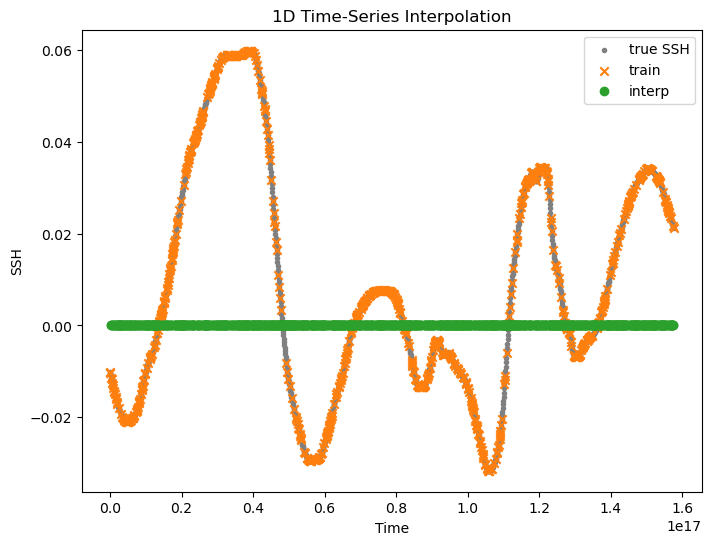

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(times, values,     c='gray', marker='.', label='true SSH')
plt.scatter(X_train, y_train,  c='C1',   marker='x', label='train')
plt.scatter(X_test,  y_pred,    c='C2',   marker='o', label='interp')
plt.xlabel("Time"); plt.ylabel("SSH")
plt.legend(); plt.title("1D Time-Series Interpolation")
plt.show()

In [27]:
t0 = ssh["t"].values[0]
field = ssh.sel(t=t0) 

In [29]:
lats = field["x"].values
lons = field["y"].values
XX, YY = np.meshgrid(lons, lats)   # note ordering: lon→x, lat→y
coords = np.vstack([XX.ravel(), YY.ravel()]).T
vals   = field.values.ravel()

In [31]:
k = int(len(vals) * 0.1)  # e.g. 10%
idx2 = np.random.choice(len(vals), size=k, replace=False)
train_coords = coords[idx2]
train_vals   = vals[idx2]
test_coords  = np.delete(coords, idx2, axis=0)
test_vals    = np.delete(vals,    idx2, axis=0)

In [33]:
gp_spat = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
gp_spat.fit(train_coords, train_vals)

C:\Users\ABHISHEK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=5)

In [34]:
pred_vals = gp_spat.predict(test_coords)
mse2 = mean_squared_error(test_vals, pred_vals)
print(f"Spatial interpolation MSE: {mse2:.4f}")

Spatial interpolation MSE: 0.0000


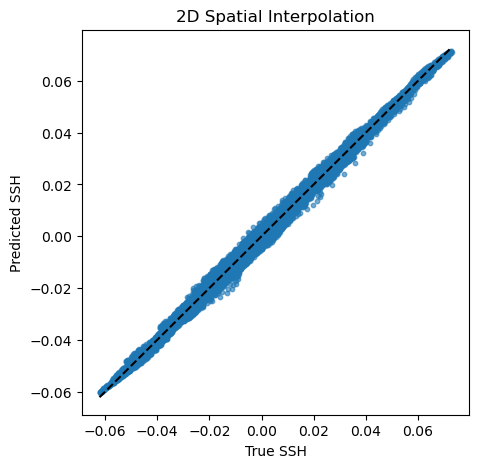

In [35]:
plt.figure(figsize=(5,5))
plt.scatter(test_vals, pred_vals, s=10, alpha=0.6)
lims = [test_vals.min(), test_vals.max()]
plt.plot(lims, lims, '--', color='k')
plt.xlabel("True SSH"); plt.ylabel("Predicted SSH")
plt.title("2D Spatial Interpolation")
plt.show()